# 7章 Stable Diffusionのファインチューニング


## 事前準備

In [1]:
!curl -L -o genaibook.zip https://github.com/oreilly-japan/hands-on-generative-ai-ja/releases/download/genaibook/genaibook.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  4678  100  4678    0     0   7990      0 --:--:-- --:--:-- --:--:--  7990


In [2]:
!unzip genaibook.zip

Archive:  genaibook.zip
Made with MacWinZipper (http://tidajapan.com/macwinzipper)
  inflating: genaibook/__init__.py   
  inflating: genaibook/core.py       


In [3]:
!pip install evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 98.4 MB/s eta 0:00:00


In [4]:
!pip install datasets==4.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.2.1 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [5]:
!pip install --no-deps trl==0.23.1 bitsandbytes==0.48.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.6/564.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 47.9 MB/s eta 0:00:00


In [6]:
from huggingface_hub import login
login()

## Stable Diffusionのフルファインチューニング

### データセットの準備

自分でデータセットを用意する場合に実行する


In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="/path/to/folder")  # パスは自分の環境に合わせて変更する

In [ ]:
dataset.push_to_hub("my-hf-username/my-incredible-dataset") # 名称は自分の環境に合わせて変更する

### モデルのファインチューニング

In [ ]:
! git clone https://github.com/huggingface/diffusers.git

Cloning into 'diffusers'...
remote: Enumerating objects: 98920, done.
remote: Counting objects: 100% (958/958), done.
remote: Compressing objects: 100% (432/432), done.
remote: Total 98920 (delta 789), reused 526 (delta 526), pack-reused 97962 (from 4)
Receiving objects: 100% (98920/98920), 74.12 MiB | 29.78 MiB/s, done.
Resolving deltas: 100% (72898/72898), done.


In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-gb7kcndj
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-gb7kcndj
  Resolved https://github.com/huggingface/diffusers.git to commit 638cc035e5ecf5c05331c449745f327dbb15e4de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.35.0.dev0-py3-none-any.whl size=4014780 sha256=9756dc911d13fca90833b1134b53235c79c448ba67358f79b4687096d5a2fac3
  Stored in directory: /tmp/pip-ephem-wheel-cache-4h6vmfbb/wheels/d2/5c/5f/16639722ea17ecb73ab461b81718584bac08af2801619786b9
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.34.0
    Uninstalling diffusers-0.34.0:
      Successfully uninstalled diffusers-0.34.0


In [ ]:
cd /content/diffusers/examples/text_to_image/

/content/diffusers/examples/text_to_image


In [ ]:
! accelerate launch train_text_to_image.py \
--pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5" \
--dataset_name="Supermaxman/esa-hubble" \
--use_ema \
--mixed_precision="fp16" \
--resolution=512 \
--center_crop \
--random_flip \
--train_batch_size=1 \
--gradient_checkpointing \
--gradient_accumulation_steps=4 \
--use_8bit_adam \
--checkpointing_steps=1000 \
--num_train_epochs=50 \
--validation_prompts \
    "Hubble image of a colorful ringed nebula: \
A new vibrant ring-shaped nebula was imaged by the \
NASA/ESA Hubble Space Telescope." \
    "Pink-tinted plumes in the Large Magellanic Cloud: \
The aggressively pink plumes seen in this image are extremely uncommon, \
with purple-tinted currents and nebulous strands reaching out into \
the surrounding space." \
--validation_epochs 5 \
--learning_rate=1e-05 \
--output_dir="sd-hubble-model" \
--report_to="tensorboard" \
--push_to_hub

### 推論

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

from genaibook.core import get_device

model_id = "Supermaxman/hubble-diffusion-1" # 自分が作成した名称に変更する
device = get_device()
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--Supermaxman--hubble-diffusion-1/snapshots/18aa4821df1dfaa80f3c17628e020cb6efefe48e/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--Supermaxman--hubble-diffusion-1/snapshots/18aa4821df1dfaa80f3c17628e020cb6efefe48e/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--Supermaxman--hubble-diffusion-1/snapshots/18aa4821df1dfaa80f3c17628e020cb6efefe48e/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--Supermaxman--hubble-diffusion-1/snapshots/18aa4821df1dfaa80f3c17628e020cb6efefe48e/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.p

  0%|          | 0/50 [00:00<?, ?it/s]

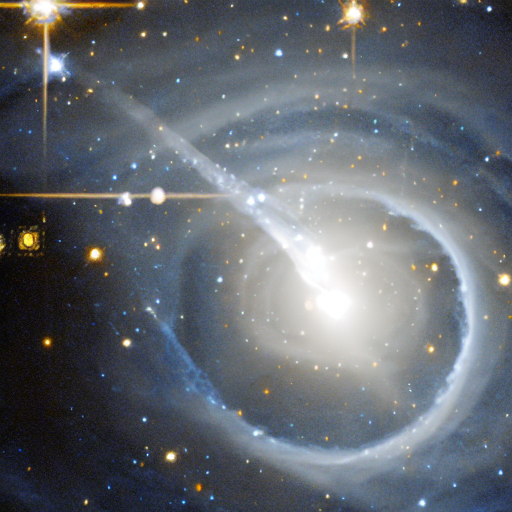

In [ ]:
prompt = (
    "Hubble reveals a cosmic dance of binary stars: In this stunning new image "
    "from the Hubble Space Telescope, a pair of binary stars orbit each other in a "
    "mesmerizing ballet of gravity and light. The interaction between these two "
    "stellar partners causes them to shine brighter, offering astronomers crucial "
    "insights into the mechanics of dual-star systems."
)

pipe(prompt).images[0]

## Dreambooth

### モデルのDreamBooth化


In [ ]:
cd /content/diffusers/examples/dreambooth

/content/diffusers/examples/dreambooth


In [ ]:
!accelerate launch train_dreambooth.py \
--pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5"  \
--instance_data_dir="/content/my-pictures" \
--class_data_dir="/content/my-pictures" \
--instance_prompt="a photo of plstps" \
--resolution=512 \
--train_batch_size=1 \
--with_prior_preservation \
--class_prompt="an ultra realistic portrait of a man" \
--gradient_accumulation_steps=1 \
--train_text_encoder \
--learning_rate=5e-6 \
--num_train_epochs=30 \
--output_dir="myself-photo-model" \
--report_to="tensorboard" \
--push_to_hub

ipex flag is deprecated, will be removed in Accelerate v1.10. From 2.7.0, PyTorch has all needed optimizations for Intel CPU and XPU.
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-07-22 02:50:09.614358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 02:50:09.630742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has alr

### 推論

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

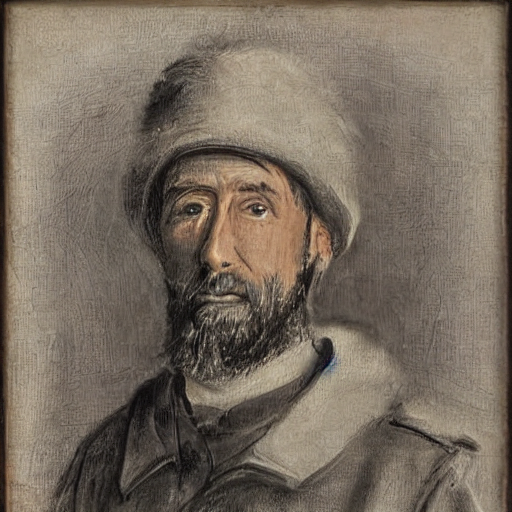

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

from genaibook.core import get_device

device = get_device()

# model_id = "your-hf-profile/myself-photo-model"  # 自分が作成した名称に変更する
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to(device)

prompt = "a photo of plstps speaking on a microphone"  # インスタンスプロンプトやカスタマイズ内容を記述する
pipe(prompt).images[0]

## LoRAの訓練

In [ ]:
from diffusers import DiffusionPipeline
from huggingface_hub.repocard import RepoCard

# クラシックな手描きの漫画風スタイルを使用する
lora_model_id = "alvdansen/littletinies"

# ベースモデルを特定する
# この情報はモデルカード内に記載されている
# 今回は "stabilityai/stable-diffusion-xl-base-1.0" となる
card = RepoCard.load(lora_model_id)
base_model_id = card.data["base_model"]

# ベースモデルを読み込む
pipe = DiffusionPipeline.from_pretrained(
    base_model_id, torch_dtype=torch.float16
)
pipe = pipe.to(device)

# LoRAをモデルに追加する
pipe.load_lora_weights(lora_model_id)

# LoRAとベースモデルを統合する
pipe.fuse_lora()

README.md: 0.00B [00:00, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.safetens(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Little_Tinies.safetensors:   0%|          | 0.00/228M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

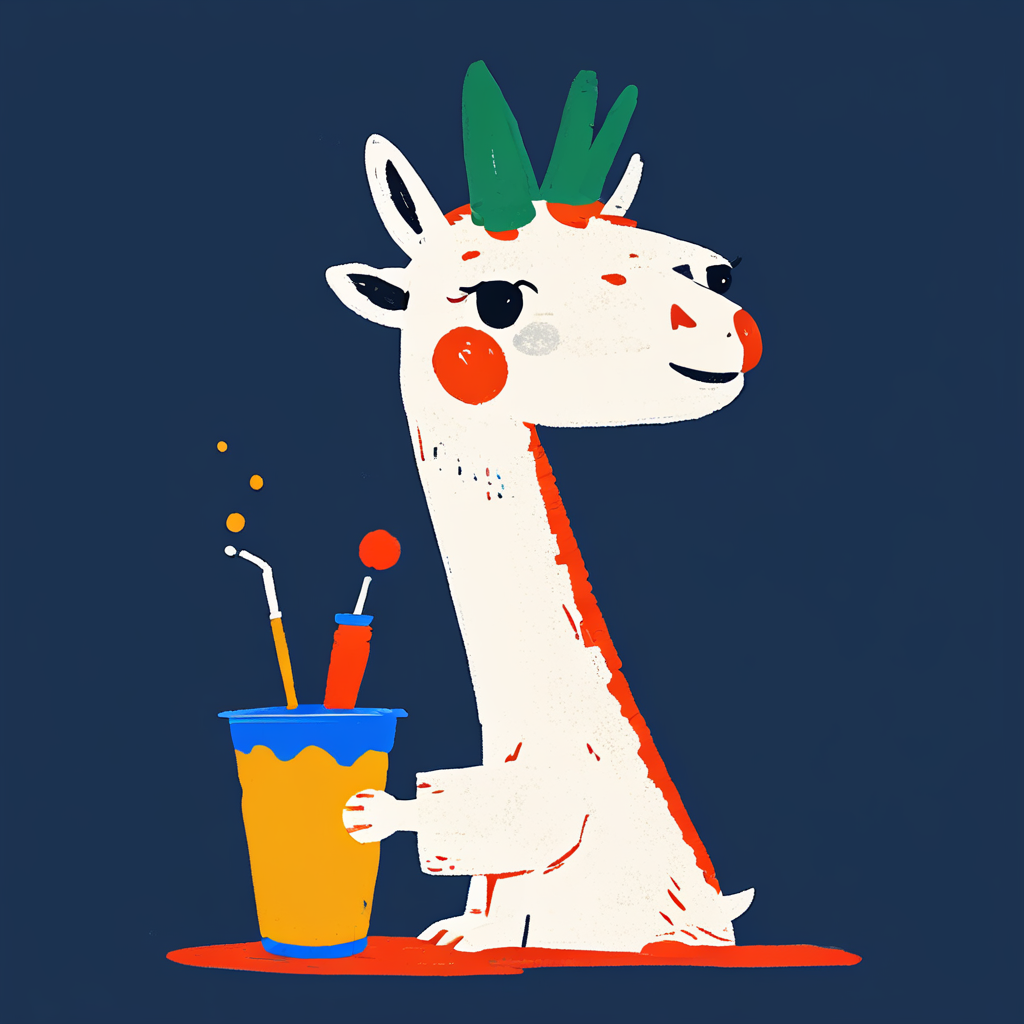

In [ ]:
image = pipe(
    "A llama drinking boba tea", num_inference_steps=25, guidance_scale=7.5
).images[0]
image

## 解答


### 演習

**1. フルモデルファインチューニングとDreamBoothの主な違いについて説明せよ。**

フルファインチューニング

* 多くのデータが必要である
* 過学習を防ぐためにデータオーグメンテーションが必要になることがある
* 破滅的忘却が発生する可能性がある

DreamBooth

* 特定のコンセプト、対象、スタイルを反映した出力が得られる
* 少数のサンプルでも動作する
* 一般的な知識を保てるため、モデルがより汎用的になる

**2. フルモデルファインチューニングと比較してLoRAを使用する利点について、計算資源やモデルの適応性の観点から述べよ。**

* モデル全体ではなく一部のみをファインチューニングするため必要な計算資源が少なくて済む。
* 低ランクパラメーターのみを保存すればよく、ストレージ容量を削減できる。
* ファインチューニングするパラメータが少ないため、より高速に訓練できる。
* 異なる低ランクパラメーターを個別に保存、管理でき、必要に応じて組み合わせたり差し替えたりすることができる。


**3. DreamBoothによる訓練において、ユニークなトークンを利用することが重要な理由は何か。**

ユニークなトークンを使用することで、新たな概念がモデル内の既存の知識と干渉しなくなる。そのため、モデルは一般的な知識を保ちながら、新たな概念に沿った出力を生成することができる。

**4. 新たな概念を教える以外に、ファインチューニングはモデルに新しい能力を付与することもできる。ファインチューニングを通じてモデルに付与できる新たな能力を2つ挙げよ。**

インペインティング
* モデルが画像の欠損部分を文脈に合った内容で補完できるようになる。
* マスクされた画像と元画像を用いてモデルをファインチューニングする。


深度認識画像生成
* モデルが3次元的な奥行きを理解し、よりリアリティのある正確な画像を生成できるようになる。
* 深度情報と対応する画像を用いてファインチューニングする。


**5. ハイパーパラメーターの選択が拡散モデルのファインチューニングの結果にどのように影響するか説明せよ。**

ハイパーパラメーターの選択は、生成画像の品質や新たな概念の学習能力に大きな影響を及ぼす。特に学習率は重要であり、高すぎると過学習や発散の原因となるが、低すぎると訓練が進まなかったり、過剰な時間を要したりする。エポック数は学習不足と過学習のバランスに関わり、少なすぎると新たな概念を十分に学習できず、多すぎると汎化能力が失われる可能性がある。バッチサイズは訓練の安定性やメモリ使用量に関係し、大きいほど勾配が安定するが、計算資源をより多く必要とする。

拡散モデルに特有のパラメーターとしては、ノイズスケジュールが既に持っている知識の保持と新たな概念の獲得とのバランスに影響を与える。オプティマイザー（AdamWや8-bit Adamなど）の選択も、訓練効率や汎化性能に影響を及ぼす。これらのハイパーパラメーターを適切に調整することで、新たな概念やスタイルを学びつつ、全体としての性能や汎用性を保ったファインチューニングが実現できる。

**6. 偏ったデータセットでテキストから画像へのモデルをファインチューニングする際に生じる潜在的なリスクについて述べよ。**

1. 訓練データ中の社会的バイアスをモデルが助長、強化する可能性がある。
2. データセットが特定のクラスや概念に偏っている場合、訓練が不均衡となり、出力も偏るリスクがある。
3. 暴力的・差別的・有害な内容でファインチューニングすると、不適切あるいは有害な画像を生成する原因となる。
4. 偏りのある出力が他のモデルやツールの訓練データとして使われ、偏りが自己強化的に拡大していく危険性がある。